<a href="https://colab.research.google.com/github/ChaitaliV/generative-explanation/blob/main/unsupervised_pretraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers sentencepiece nltk evaluate rouge bleu rouge-score
!git clone https://github.com/ChaitaliV/generative-explanation

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 13.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.1/311.1 kB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 45.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 52.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 59.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 40.0 MB/s eta 0:00:00
  Created wheel for bleu: filename=bleu-0.3-py3-none-any.whl size=5782 sha256=6a9202f15e734efc5784fba3d4e5

In [2]:
from transformers import T5Tokenizer, T5Model, T5ForConditionalGeneration, T5TokenizerFast
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from tqdm import tqdm, trange
import pandas as pd
import torch
import nltk
import evaluate
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge
from nltk.translate.bleu_score import sentence_bleu
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### Evaluate the model performace before and after pre-training

* take few sentences and tokenize them, mask one word from each sentence, and use model to predict the masked word.
* use model logits to get candidates for the masked word.
* calculate the rogue score between original and generated sentences.
* plot the graph of scores.

In [3]:
depression_symptoms = [
    "Persistent sadness and a sense of hopelessness are common symptoms of depression.",
    "Changes in sleep patterns, such as insomnia or oversleeping, may indicate depressive symptoms.",
    "Fatigue and a lack of energy are often reported by individuals experiencing depression.",
    "Difficulty concentrating or making decisions is a cognitive symptom associated with depression.",
    "Feelings of worthlessness or excessive guilt can be indicative of depressive thoughts.",
    "Loss of interest or pleasure in activities once enjoyed is a hallmark symptom of depression.",
    "Appetite changes, leading to weight loss or gain, can be part of depressive symptoms.",
    "Irritability and restlessness are emotional symptoms that may accompany depression.",
    "Physical symptoms of depression may include headaches and unexplained body aches.",
    "Thoughts of death or suicide are severe symptoms requiring immediate attention.",
    "Social withdrawal and isolation are behavioral signs often seen in depression.",
    "Decreased libido and sexual dysfunction can be associated with depressive disorders.",
    "Psychomotor agitation or retardation may affect an individual's physical movements.",
    "Recurrent thoughts of death or suicide should be taken seriously and addressed promptly.",
    "Depressive symptoms in children may manifest as irritability and academic decline.",
    "Seasonal changes can contribute to Seasonal Affective Disorder (SAD), a subtype of depression.",
    "Anxiety often coexists with depression, and symptoms may overlap.",
    "Physical complaints, such as digestive issues, may be linked to underlying depression.",
    "Persistent feelings of emptiness and a lack of purpose are emotional symptoms of depression.",
    "Postpartum depression affects some women after giving birth and requires prompt diagnosis and treatment to support maternal well-being."
]

In [4]:
masks = ['sadness', 'oversleeping','lack', 'cognitive','excessive', 'pleasure',
         'Appetite','restlessness', 'headaches', 'suicide', 'behavioral', 'dysfunction',
         'physical', 'seriously', 'children', 'Disorder', 'coexists', 'depression',
         'symptoms', 'Postpartum'
         ]

In [5]:
depression_symptoms_masked = [
    "Persistent <extra_id_0> and a sense of hopelessness are common symptoms of depression.",
    "Changes in sleep patterns, such as insomnia or <extra_id_0>, may indicate depressive symptoms.",
    "Fatigue and a <extra_id_0> of energy are often reported by individuals experiencing depression.",
    "Difficulty concentrating or making decisions is a <extra_id_0> symptom associated with depression.",
    "Feelings of worthlessness or <extra_id_0> guilt can be indicative of depressive thoughts.",
    "Loss of interest or <extra_id_0> in activities once enjoyed is a hallmark symptom of depression.",
    "<extra_id_0> changes, leading to weight loss or gain, can be part of depressive symptoms.",
    "Irritability and <extra_id_0> are emotional symptoms that may accompany depression.",
    "Physical symptoms of depression may include <extra_id_0> and unexplained body aches.",
    "Thoughts of death or <extra_id_0> are severe symptoms requiring immediate attention.",
    "Social withdrawal and isolation are <extra_id_0> signs often seen in depression.",
    "Decreased libido and sexual <extra_id_0> can be associated with depressive disorders.",
    "Psychomotor agitation or retardation may affect an individual's <extra_id_0> movements.",
    "Recurrent thoughts of death or suicide should be taken <extra_id_0> and addressed promptly.",
    "Depressive symptoms in <extra_id_0> may manifest as irritability and academic decline.",
    "Seasonal changes can contribute to Seasonal Affective <extra_id_0>(SAD), a subtype of depression.",
    "Anxiety often <extra_id_0> with depression, and symptoms may overlap.",
    "Physical complaints, such as digestive issues, may be linked to underlying <extra_id_0>.",
    "Persistent feelings of emptiness and a lack of purpose are emotional <extra_id_0> of depression.",
    "<extra_id_0> depression affects some women after giving birth and requires prompt diagnosis and treatment to support maternal well-being."
]

In [6]:
def eval_model(model_name):
  candidate_list = []
  for i in range(0, len(depression_symptoms_masked)):
    input_ids = tokenizer(depression_symptoms_masked[i], max_length= 512, padding="max_length",truncation=True, pad_to_max_length=True, add_special_tokens=True,return_tensors="pt").input_ids
    outputs = model_name.generate(input_ids)
    candidates = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
    candidate_list.append(candidates[0].split(' ')[0])
  return candidate_list

## Model evaluation before pre-training

In [7]:
tokenizer = T5Tokenizer.from_pretrained("t5-base")
model = T5ForConditionalGeneration.from_pretrained("t5-base")

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5.py:240: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the

In [8]:
labels_list = eval_model(model)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [9]:
rouge = evaluate.load('rouge')
results = rouge.compute(predictions= labels_list,references=masks)
print(results)

{'rouge1': 0.3, 'rouge2': 0.0, 'rougeL': 0.3, 'rougeLsum': 0.3}


In [10]:
before_training = pd.DataFrame({'actual_word':masks, 'pred_word': labels_list})
before_training

,actual_word,pred_word
0,sadness,depression
1,oversleeping,REM
2,lack,lack
3,cognitive,common
4,excessive,feelings
5,pleasure,participation
6,Appetite,Lifestyle
7,restlessness,irritability
8,headaches,headaches
9,suicide,sudden


## Model Pre-training

In [18]:
tokenizer = T5Tokenizer.from_pretrained("t5-base")
trained_model = T5ForConditionalGeneration.from_pretrained("t5-base", return_dict=True)
device = 'cuda:0'
batch_size = 4
epochs = 5
optimizer = AdamW(trained_model.parameters(), lr=0.0001)

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5.py:240: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecate

In [12]:
df = pd.read_csv('generative-explanation/datasets/unsupervised dataset/unsupervised_dataset.csv')

In [13]:
input_ids = df.Encoder
labels = df.Decoder

In [14]:
class Prepare_Data():
  """
  this class will take the dataframe and,
  -- tokenize the text, get input_ids, attention_masks, and labels
  -- make train-validation split
  -- create dataloaders for training and validation data
  """
  def __init__(self, tokenizer, dframe):
    self.tokenizer = tokenizer
    self.data = dframe
    self.sentences = self.data.Encoder.values
    self.responses = self.data.Decoder.values


  def prepare_dataloader(self):
    # tokenize pattern + tag (as input features- encoder)
    pattern_tokenized = self.tokenizer([str(sequence) for sequence in self.sentences], max_length= 512, padding="max_length",
                                                    truncation=True, pad_to_max_length=True, add_special_tokens=True,return_tensors="pt")

    # tokenize target response(as target - decoder)
    response_tokenized = self.tokenizer([str(response) for response in self.responses], max_length= 512, padding="max_length",
                                          truncation=True, pad_to_max_length=True, add_special_tokens=True, return_tensors = "pt")


    ## get labels, input_ids, and attention_mask
    labels = response_tokenized.input_ids
    labels[labels == tokenizer.pad_token_id] = -100
    input_ids = pattern_tokenized.input_ids
    attention_mask = pattern_tokenized.attention_mask

    #create train, validation split
    train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels,random_state = 2018, test_size = 0.1 )
    train_masks, validation_masks, _, _ = train_test_split(attention_mask, input_ids,
                                             random_state=2018, test_size=0.1)

    #create dataloaders for training and validation data
    train_data = TensorDataset(train_inputs, train_masks, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
    validation_sampler = SequentialSampler(validation_data)
    validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

    return train_dataloader, validation_dataloader

In [15]:
LoadData = Prepare_Data(tokenizer, df)
train_dataloader, validation_dataloader = LoadData.prepare_dataloader()

In [19]:
trained_model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [20]:
# The Training Loop
t = []
# Store our loss and accuracy for plotting
train_loss_set = []
val_loss_set = []

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):

  # Training

  #set model in training mode
  trained_model.train()

  #tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0

  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    #clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    #forward pass
    outputs = trained_model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs['loss']
    #backward pass
    loss.backward()
    #update parameters and take a step using the computed gradient
    optimizer.step()

    #update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1
  train_loss = tr_loss/nb_tr_steps
  train_loss_set.append(train_loss)

  print("Train loss: {}".format(train_loss))


  # Evaluation

  #put model in evaluation mode to evaluate loss on the validation set
  trained_model.eval()

  #tracking variables
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  #evaluate data for one epoch
  for batch in validation_dataloader:
    #add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    #unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    #telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      outputs = trained_model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
    e_loss = outputs['loss']

    #calculate loss for the whole batch
    eval_loss += e_loss.item()
    nb_eval_steps += 1

  val_loss = eval_loss/nb_eval_steps
  val_loss_set.append(val_loss)

  print("Validation loss: {}".format(val_loss))


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.38746432775657996


Epoch:  20%|██        | 1/5 [09:34<38:18, 574.64s/it]

Validation loss: 0.34095949977636336
Train loss: 0.3088832992387833


Epoch:  40%|████      | 2/5 [19:10<28:45, 575.29s/it]

Validation loss: 0.2993732367049564
Train loss: 0.2689462783226921


Epoch:  60%|██████    | 3/5 [28:46<19:11, 575.61s/it]

Validation loss: 0.2761715769090436
Train loss: 0.23599562806815938


Epoch:  80%|████████  | 4/5 [38:21<09:35, 575.38s/it]

Validation loss: 0.23620102405548096
Train loss: 0.20816187903617506


Epoch: 100%|██████████| 5/5 [47:57<00:00, 575.47s/it]

Validation loss: 0.22185502086173403


In [24]:
import matplotlib.pyplot as plt
import numpy as np

[]

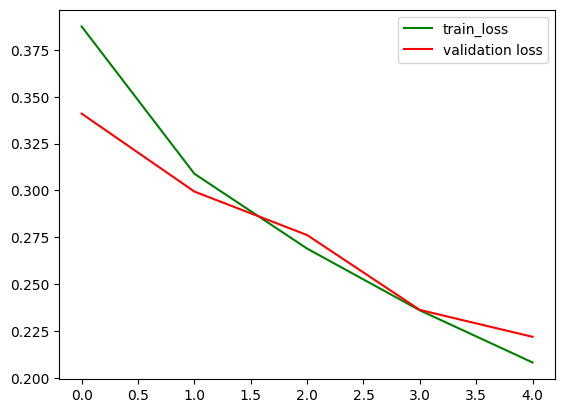

In [25]:
plt.plot(np.arange(0, len(train_loss_set)), train_loss_set, color = 'g', label = 'train_loss')
plt.plot(np.arange(0,len(val_loss_set)), val_loss_set, color = 'r', label = 'validation loss')
plt.legend()
plt.plot()

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
torch.save(model,r'/content/drive/MyDrive/T5_pretrained.pt')

### evaluate pre-trained model

In [30]:
trained_model.to('cpu')

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [31]:
trained_labels_list = eval_model(trained_model)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [33]:
rouge = evaluate.load('rouge')
results = rouge.compute(predictions= trained_labels_list,references=masks)
print(results)

{'rouge1': 0.4, 'rouge2': 0.0, 'rougeL': 0.4, 'rougeLsum': 0.4}


In [34]:
compare_words = pd.DataFrame({'actual':masks, 'before_training': labels_list,'after_training':trained_labels_list})
compare_words

,actual,before_training,after_training
0,sadness,depression,sadness
1,oversleeping,REM,slumber
2,lack,lack,loss
3,cognitive,common,common
4,excessive,feelings,excessive
5,pleasure,participation,enjoyment
6,Appetite,Lifestyle,.
7,restlessness,irritability,irritability
8,headaches,headaches,irritable
9,suicide,sudden,suicide
